In [1]:
import numpy as np
import simulation_manager, results_annalysis
import matplotlib.pyplot as plt
import time
import pandas as pd

# **Defining the reduction**

In [2]:
def P_aug(N,bit): 
    P = np.zeros((N,N*bit))
    b = np.array([2**i for i in range(bit)])
    for i in range(N):
        debut = i*bit
        fin = debut + bit 
        P[i,debut:fin] = b 

    return P 

In [3]:
def reduction(sigma,mu,c,alpha,K,previous_solution = 0,first= False):
    """
    From the covariance matrix and the excpected return vector returns the J and H 
    of the Ising mapping 

    ARGS: 
    sigma: covariance matrix 
    mu: excpected return vector
    alpha : aversion constant 
    K : The budget 
    penalty: If we add the constraint in the energy 
    Output: 
    J : 
    H: 
    """
    Bit_max = int(np.log2(K))
    bit = 1#Bit_max
    N = len(mu) # Number of assets considered 
    U = np.ones(bit*N) 
    P = P_aug(N,bit)
    sigma_augmented = P.T @ sigma @ P
    mu_augmented = P.T @ mu 
    lambda_augmented = c*P.T@P
    if not first: 
        J = - (alpha/2)* sigma_augmented- lambda_augmented/2
        H = (alpha/2) * sigma_augmented @ U - mu_augmented - (1/2)*lambda_augmented @previous_solution
        np.fill_diagonal(J,0)
        return  J,H
    else: 
        J_first = - (alpha/2)* sigma_augmented
        H_first = (alpha/2) * sigma_augmented @ U - mu_augmented
        np.fill_diagonal(J_first,0)
        return J_first,H_first

In [4]:
def reverse(solution,N,K): 
    solution += 1
    solution /=2
    bit = int(np.log2(K))
    P = P_aug(N,bit)
    return P@solution

# **Creating an artificial market**

Estimated μ_t for the first 10 periods:
 [[0.14296    0.13090858 0.13391672 0.12390659 0.11933946 0.1075657
  0.08505455 0.10840926 0.11108633 0.08797537 0.06684441 0.04102967
  0.03318179 0.03200807 0.0350396  0.03158269 0.03562998 0.02170645
  0.03693279 0.03906127]
 [0.07120455 0.03979595 0.03076556 0.03288052 0.0320618  0.01878349
  0.01389776 0.02224545 0.05045027 0.0338063  0.0362541  0.0321404
  0.03658861 0.03972402 0.06923686 0.10357499 0.08564732 0.07911635
  0.08111369 0.09507657]
 [0.07127366 0.06160904 0.07367975 0.06501036 0.07107035 0.06598276
  0.07010507 0.08213783 0.09965539 0.10740373 0.12547802 0.12268433
  0.14110956 0.15153426 0.15796161 0.1736517  0.20237005 0.20766476
  0.19249409 0.14614458]]

Estimated σ_t for the first 10 periods:
 [[[ 4.71204847e-02  4.71836568e-02  4.56914684e-02  4.76060972e-02
    4.88170310e-02  4.74556987e-02  4.42076189e-02  4.23325959e-02
    4.46198911e-02  5.05537992e-02  4.42220400e-02  4.63258963e-02
    4.60390073e-02  4.59024794

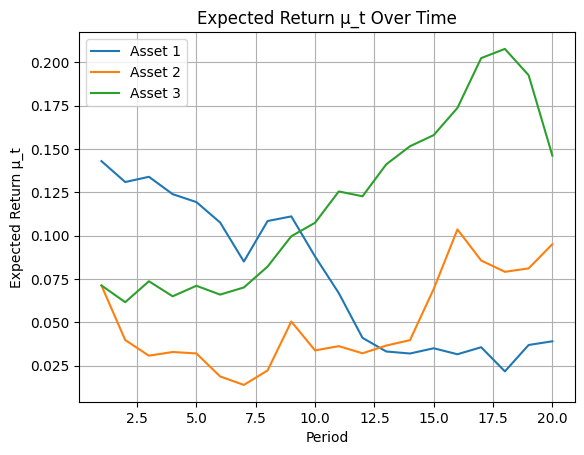

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def geometric_brownian_motion(n_assets, n_time, initial_prices, drift=0.1, volatility=0.2):
    """Generate price paths from a geometric Brownian motion."""
    dt = 1  # Time step
    prices = np.zeros((n_assets, n_time))
    prices[:, 0] = initial_prices

    for i in range(n_assets):
        for t in range(1, n_time):
            prices[i, t] = prices[i, t - 1] * np.exp((drift - 0.5 * volatility**2) * dt +
                                                     volatility * np.sqrt(dt) * np.random.normal())

    return prices

def rolling_window_estimation(prices, window_size):
    """Estimate future return vector μ and covariance matrix S over rolling windows."""
    n_assets, n_time = prices.shape
    n_windows = n_time - window_size + 1
    mu_t = np.zeros((n_assets, n_windows))
    sigma_t = np.zeros((n_assets, n_assets, n_windows))

    for t in range(n_windows):
        window_prices = prices[:, t:t + window_size]
        returns = np.diff(window_prices, axis=1) / window_prices[:, :-1]
        mu_t[:, t] = np.mean(returns, axis=1)
        sigma_t[:, :, t] = np.cov(returns)

    return mu_t, sigma_t

# Parameters
N = 3  # Number of assets
T = 200  # Total number of time increments
initial_prices = np.random.uniform(100, 120, N)
window_size = 20  # Monthly window size (assuming 20 trading days per month)

# Simulate price paths
prices = geometric_brownian_motion(N, T, initial_prices, drift=0.1, volatility=0.2)

# Estimate μ_t and σ_t over rolling windows
mu_t, sigma_t = rolling_window_estimation(prices, window_size)

# Select the first 10 periods for the results
mu_t_10 = mu_t[:, :20]
sigma_t_10 = sigma_t[:, :, :20]

# Print the results
print("Estimated μ_t for the first 10 periods:\n", mu_t_10)
print("\nEstimated σ_t for the first 10 periods:\n", sigma_t_10)

# Visualization
time_points = np.arange(1, 21)
for i in range(N):
    plt.plot(time_points, mu_t_10[i], label=f'Asset {i+1}')
plt.xlabel('Period')
plt.ylabel('Expected Return μ_t')
plt.title('Expected Return μ_t Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
sigma_t[:,:,0].shape

(3, 3)

In [7]:
def find_optimal_portfolio(sigma,mu,c,alpha,K,previous_solution= 0,first =False,visualize = False):
    """
    Find optimal portfolio using Simulated bifurcations 
    Args: 
    sigma : 
    mu : 
    previous_solution 
    first : 
    visualize: 
    """

    
    J,H = reduction(sigma,mu,c,alpha,K,previous_solution,first)

    # Defining the Pumping rate 
    eigs = np.linalg.eigvals(J)
    norm_eigs = np.abs(eigs)
    ksi = 1/(norm_eigs.max())
    p_first = 1-ksi*np.real(eigs.max())
    p_last = 1-ksi*np.real(eigs.min())

    num_iterations= 2000
    lag = 0 

    def pumping_rate(self, t):
        # return t/100
        if t<lag:
            return 0
        else:
            return 1 * p_last * (t-lag)/(num_iterations-lag)
        
    # 
    manager = simulation_manager.SimulationManager(step_size=0.5, num_iterations=num_iterations, num_simulations=2, J=J, H=H, pumping_rate=pumping_rate, stopping_criterion=0.1, save_states_history=True, save_energies_history=True, n_threads=2, savetofile=False)
    states, energies, last_states, _, _, _, _, _, _, _, _ = manager.run_simulation()

    if visualize: 
        results_annalysis.complete_plot(states, energies, 0)

    return np.sign(last_states[0, :, 0])



# **Testing and visualizing the trading trajectory**

C:\Users\nesri\AppData\Local\Temp\ipykernel_16604\2149670900.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  ksi = 1/(norm_eigs.max())
C:\Users\nesri\AppData\Local\Temp\ipykernel_16604\2149670900.py:19: RuntimeWarning: invalid value encountered in scalar multiply
  p_first = 1-ksi*np.real(eigs.max())
C:\Users\nesri\AppData\Local\Temp\ipykernel_16604\2149670900.py:20: RuntimeWarning: invalid value encountered in scalar multiply
  p_last = 1-ksi*np.real(eigs.min())
c:\Users\nesri\SB_Algorithm_applications\SBM.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  self.ksi = 1/np.linalg.eigvals(self.J).max()
c:\Users\nesri\SB_Algorithm_applications\SBM.py:99: RuntimeWarning: invalid value encountered in multiply
  forces = -np.dot(self.J, positions.T).T * self.ksi


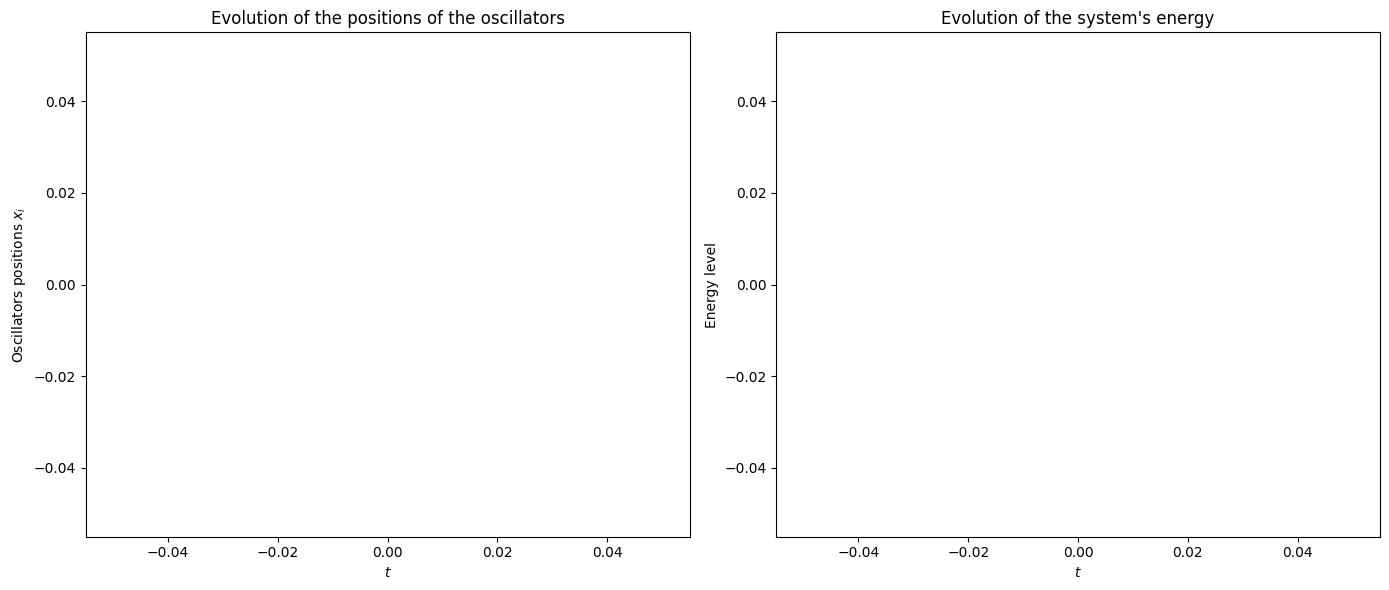

In [8]:
c = 0.01
alpha= 0
K = 3
solution_0= find_optimal_portfolio(sigma_t[:,:,0],mu_t[:,0],c,alpha,K,first = True,visualize=True)
Trajectory_solutions = [solution_0]

for t in range(1,21): 
    solution_t = find_optimal_portfolio(sigma_t[:,:,t],mu_t[:,t],c,alpha,K,previous_solution=Trajectory_solutions[t-1])
    Trajectory_solutions.append(solution_t)


In [9]:
Trajectory_weights= [reverse(solution,N,K) for solution in Trajectory_solutions]


In [10]:
Trajectory_weights[0]

array([nan, nan, nan])

In [11]:
def calculate_trajectory_value(sigma_t, mu_t,Trajectory_weights,c):
    T = len(Trajectory_weights)
    total_value = np.zeros(T)
    return_component = np.zeros(T)
    risk_component = np.zeros(T)
    
    for t in range(T):
        sigma = sigma_t[:,:,t]
        mu = mu_t[:,t]
        S = Trajectory_weights[t]
        
        # delta_w = delta_w_t[t]
        # L = L_t[t]
        
        return_component[t] = S.T @ mu
        risk_component[t] = S.T @ sigma @ S 
        if t>1: 
            trading_costs = c * np.sum(np.abs(Trajectory_weights[t]- Trajectory_weights[t-1]))
        else: 
            trading_costs = 0
        total_value[t] = return_component[t] - risk_component[t] - trading_costs
    
    return total_value, return_component, risk_component



In [12]:
# Creating the universe of possible trajectories
trajectories_universe =[]
for _ in range(100000):
    trajectory = np.random.uniform(0,K,size=(len(Trajectory_weights),N))
    trajectories_universe.append(trajectory)


# **Visualizing the trading trajectory**

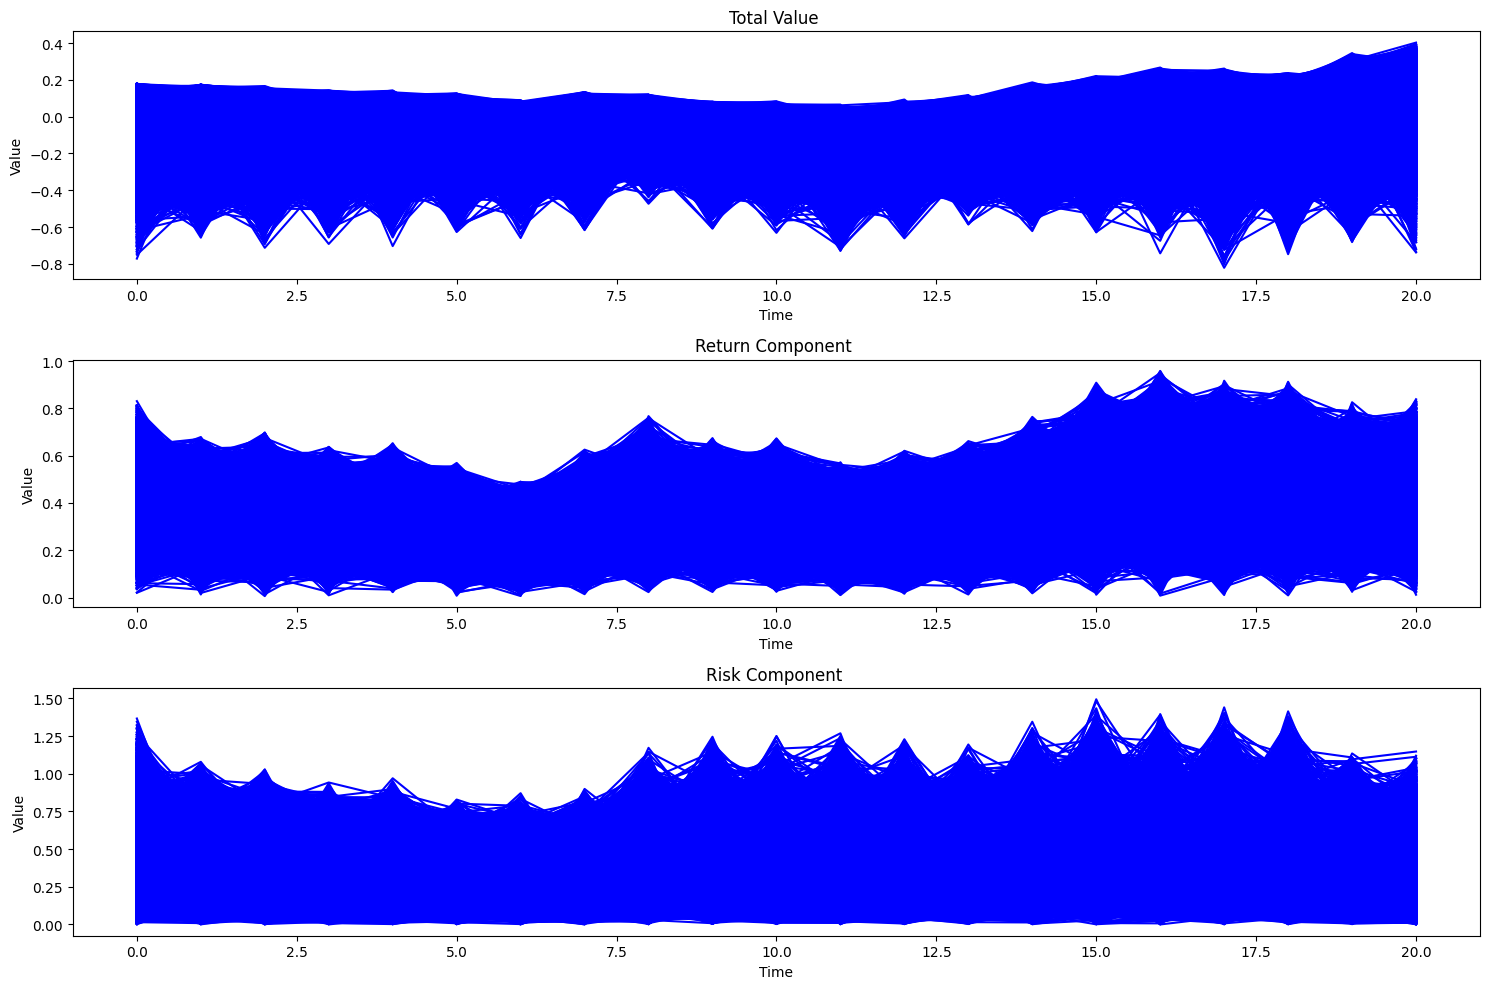

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i in range(10000):
    total_value,return_component,risk_component = calculate_trajectory_value(sigma_t, mu_t,trajectories_universe[i],c)
    axes[0].plot(total_value,'b')
    axes[1].plot(return_component,'b')
    axes[2].plot(risk_component,'b')
total_value,return_component,risk_component = calculate_trajectory_value(sigma_t,mu_t,Trajectory_weights,c)

# Plot total value
axes[0].plot(total_value, 'r',linewidth = 5, label='Total Value')
axes[0].set_title(f'Total Value ')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')

# Plot return component
axes[1].plot(return_component, 'r',linewidth = 5, label='Return Component')
axes[1].set_title(f'Return Component ')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')

# Plot risk component
axes[2].plot(risk_component, 'r',linewidth = 5,  label='Risk Component')
axes[2].set_title(f'Risk Component ')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Value')




plt.tight_layout()
plt.show()

